In [22]:
import numpy as np
import torch
import torch.nn as nn
from matplotlib import pyplot as plt

from torch.utils.data.dataloader import DataLoader
from torch.utils.data import random_split

from tsdart.utils import set_random_seed
from tsdart.loss import Prototypes
from tsdart.model import TSDART, TSDARTLayer, TSDARTEstimator
from tsdart.dataprocessing import Preprocessing

In [23]:
if torch.cuda.is_available():
    device = torch.device('cuda')
    print('cuda is available')
else:
    device = torch.device('cpu')
    print('cpu')

cuda is available


### Muller potential

Text(0, 0.5, 'x2')

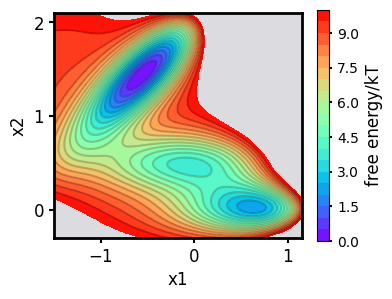

In [24]:
A = np.array([-10,-5,-17/2,0.75])
a = np.array([-1,-1,-6.5,0.7])
b = np.array([0,0,11,0.6])
c = np.array([-10,-10,-6.5,0.7])
xbar = np.array([1,0,-0.5,-1])
ybar = np.array([0,0.5,1.5,1])

def V(x,y):
    s = 0.
    for i in range(4):
        s += A[i]*np.exp(a[i]*(x-xbar[i])**2+b[i]*(x-xbar[i])*(y-ybar[i])+c[i]*(y-ybar[i])**2) 
    return s

fig,ax = plt.subplots(1,1,figsize=(4,3))
for axis in ['top','bottom','left','right']:
    ax.spines[axis].set_linewidth(2)
ax.set_aspect('equal')
x = np.arange(-1.7,1.2+0.01,0.01)
y = np.arange(-0.35,2.1+0.01,0.01)
xx,yy = np.meshgrid(x,y)
z = V(xx.ravel(),yy.ravel()).reshape(len(y),-1)
z = z - z.min()
z = z*1/0.9 # temperature is 0.4.
z = np.ma.masked_greater(z, 10)
c = ax.contourf(x,y,z,cmap='rainbow',levels=20,zorder=1)
ax.contour(x,y,z,levels=20,zorder=1,colors='black',alpha=0.2)
cb = fig.colorbar(c)
#ax.grid(True)
ax.tick_params(axis="both",labelsize=12,direction='out',length=3.5,width=1.5)
cb.ax.tick_params(labelsize=10,length=2.5,width=1.5)
cb.set_label('free energy/kT',fontsize=12)

ax.set_xlim(-1.5,1.15)
ax.set_ylim(-0.3,2.1)

ax.set_yticks([0,1,2])

r=0.1
g=0.1
b=0.2
ax.patch.set_facecolor((r,g,b,.15))

ax.set_xlabel('x1',fontsize=12)
ax.set_ylabel('x2',fontsize=12)

### Create dataset

In [25]:
data = np.load('../data/muller/muller.npy')

pre = Preprocessing(dtype=np.float32)
dataset = pre.create_dataset(lag_time=1,data=data)

### 2 states model

In [26]:
set_random_seed(1)

val = int(len(dataset)*0.10)
train_data, val_data = torch.utils.data.random_split(dataset, [len(dataset)-val, val])

loader_train = DataLoader(train_data, batch_size=10000, shuffle=True)
loader_val = DataLoader(val_data, batch_size=len(val_data), shuffle=False)

lobe = TSDARTLayer([2,20,20,20,10,2],n_states=2)
lobe = lobe.to(device=device)
### 50 epochs for fully optimization
tsdart = TSDART(lobe = lobe, learning_rate = 1e-3, device = device, mode = 'regularize', beta=0.01, feat_dim=2, n_states=2, pretrain=50, fast_mode=True)
tsdart_model = tsdart.fit(loader_train, n_epochs=100, validation_loader=loader_val).fetch_model()

In [27]:
tsdart_estimator = TSDARTEstimator(tsdart_model)
ood_scores = tsdart_estimator.fit(data).ood_scores

Text(0, 0.5, 'x2')

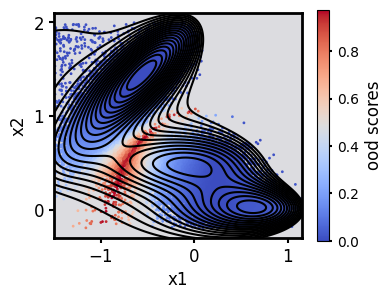

In [28]:
A = np.array([-10,-5,-17/2,0.75])
a = np.array([-1,-1,-6.5,0.7])
b = np.array([0,0,11,0.6])
c = np.array([-10,-10,-6.5,0.7])
xbar = np.array([1,0,-0.5,-1])
ybar = np.array([0,0.5,1.5,1])

def V(x,y):
    s = 0.
    for i in range(4):
        s += A[i]*np.exp(a[i]*(x-xbar[i])**2+b[i]*(x-xbar[i])*(y-ybar[i])+c[i]*(y-ybar[i])**2)
    return s

fig,ax = plt.subplots(1,1,figsize=(4,3))
for axis in ['top','bottom','left','right']:
    ax.spines[axis].set_linewidth(2)
ax.set_aspect('equal')
x = np.arange(-1.7,1.2+0.01,0.01)
y = np.arange(-0.35,2.1+0.01,0.01)
xx,yy = np.meshgrid(x,y)
z = V(xx.ravel(),yy.ravel()).reshape(len(y),-1)
z = z - z.min()
z = z*1/0.9 # temperature is 0.4.
z = np.ma.masked_greater(z, 10)

c = ax.scatter(data[:,0],data[:,1],c=ood_scores,cmap='coolwarm',s=1,alpha=1)
cb = fig.colorbar(c)
cb.ax.tick_params(labelsize=10,length=2.5,width=1.5)
cb.set_label('ood scores',fontsize=12)

ax.contour(x,y,z,levels=20,zorder=1,colors='black',alpha=1)

ax.tick_params(axis="both",labelsize=12,direction='out',length=3.5,width=1.5)

ax.set_xlim(-1.5,1.15)
ax.set_ylim(-0.3,2.1)

ax.set_yticks([0,1,2])

r=0.1
g=0.1
b=0.2
ax.patch.set_facecolor((r,g,b,.15))

ax.set_xlabel('x1',fontsize=12)
ax.set_ylabel('x2',fontsize=12)

In [29]:
features = tsdart_model.transform(data,return_type='hypersphere_embs')
state_centers = tsdart_estimator.fit(data).state_centers

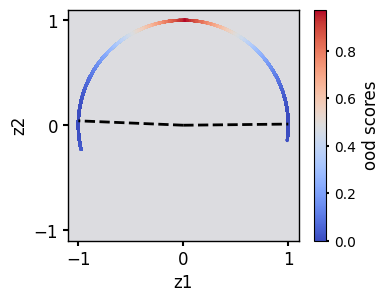

In [30]:
fig,ax = plt.subplots(1,1,figsize=(4,3))
for axis in ['top','bottom','left','right']:
    ax.spines[axis].set_linewidth(1)
ax.set_aspect('equal')

c = ax.scatter(features[:,0],features[:,1],c=ood_scores,cmap='coolwarm',s=1,alpha=1)
cb = fig.colorbar(c)
cb.ax.tick_params(labelsize=10,length=2.5,width=1.5)
cb.set_label('ood scores',fontsize=12)

ax.plot([0,state_centers[0,0]],[0,state_centers[0,1]],linewidth=2,color='black',linestyle='--')
ax.plot([0,state_centers[1,0]],[0,state_centers[1,1]],linewidth=2,color='black',linestyle='--')

ax.tick_params(axis="both",labelsize=12,direction='out',length=3.5,width=1.5)

ax.set_xlim(-1.1,1.1)
ax.set_ylim(-1.1,1.1)

ax.set_xticks([-1,0,1])
ax.set_yticks([-1,0,1])

ax.set_xlabel('z1',fontsize=12)
ax.set_ylabel('z2',fontsize=12)

r=0.1
g=0.1
b=0.2
ax.patch.set_facecolor((r,g,b,.15))

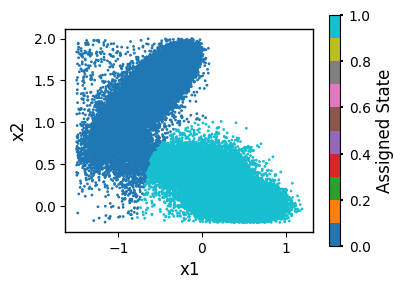

In [31]:
assigned_states = tsdart_model.transform(data, return_type='states').astype(int)

fig, ax = plt.subplots(1, 1, figsize=(4, 3))
for axis in ['top', 'bottom', 'left', 'right']:
    ax.spines[axis].set_linewidth(1)
ax.set_aspect('equal')

scatter = ax.scatter(data[:, 0], data[:, 1], c=assigned_states, cmap='tab10', s=1, alpha=1)
cb = fig.colorbar(scatter)
cb.ax.tick_params(labelsize=10, length=2.5, width=1.5)
cb.set_label('Assigned State', fontsize=12)

ax.set_xlabel('x1', fontsize=12)
ax.set_ylabel('x2', fontsize=12)
plt.show()

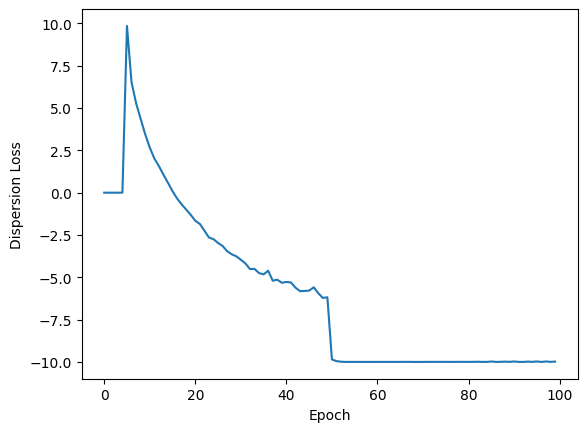

In [32]:
# dispersion loss
disloss = tsdart._validation_dis

plt.plot(range(len(disloss)), disloss)
plt.xlabel('Epoch')
plt.ylabel('Dispersion Loss')
plt.show()

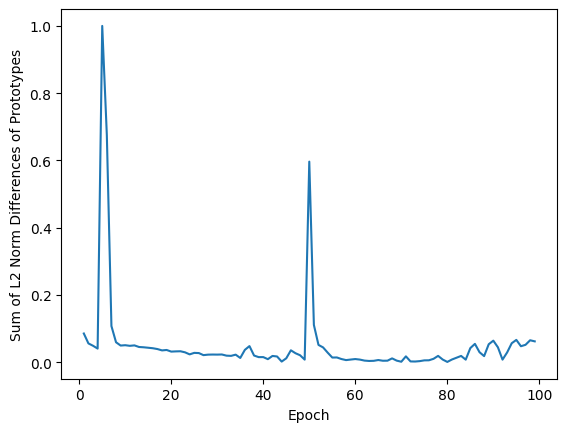

In [33]:
# prototypes_history: list of tensors, each [n_states, feat_dim]
prototypes_history = tsdart.validation_prototypes
l2_diffs = []
for i in range(1, len(prototypes_history)):
    prev = prototypes_history[i-1]
    curr = prototypes_history[i]
    # compute L2-norm difference for each prototype
    diff = np.linalg.norm(curr - prev, axis=1)
    # max(Delta(L2-norm))
    l2_diffs.append(diff.max())

plt.plot(range(1, len(prototypes_history)), l2_diffs)
plt.xlabel('Epoch')
plt.ylabel('Sum of L2 Norm Differences of Prototypes')
plt.show()

### 3 states model

In [34]:
set_random_seed(1)

val = int(len(dataset)*0.10)
train_data, val_data = torch.utils.data.random_split(dataset, [len(dataset)-val, val])

loader_train = DataLoader(train_data, batch_size=1000, shuffle=True)
loader_val = DataLoader(val_data, batch_size=len(val_data), shuffle=False)

lobe = TSDARTLayer([2,20,20,20,10,2],n_states=3)
lobe = lobe.to(device=device)
### 50 epochs for fully optimization
tsdart = TSDART(lobe = lobe, learning_rate = 5e-4, device = device, mode = 'regularize', beta=0.01, feat_dim=2, n_states=3, pretrain=100, fast_mode=True)
tsdart_model = tsdart.fit(loader_train, n_epochs=200, validation_loader=loader_val).fetch_model()

In [35]:
tsdart_estimator = TSDARTEstimator(tsdart_model)
ood_scores = tsdart_estimator.fit(data).ood_scores

Text(0, 0.5, 'x2')

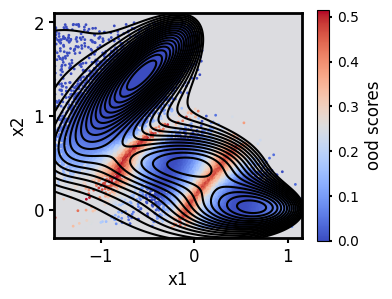

In [36]:
A = np.array([-10,-5,-17/2,0.75])
a = np.array([-1,-1,-6.5,0.7])
b = np.array([0,0,11,0.6])
c = np.array([-10,-10,-6.5,0.7])
xbar = np.array([1,0,-0.5,-1])
ybar = np.array([0,0.5,1.5,1])

def V(x,y):
    s = 0.
    for i in range(4):
        s += A[i]*np.exp(a[i]*(x-xbar[i])**2+b[i]*(x-xbar[i])*(y-ybar[i])+c[i]*(y-ybar[i])**2) 
    return s

fig,ax = plt.subplots(1,1,figsize=(4,3))
for axis in ['top','bottom','left','right']:
    ax.spines[axis].set_linewidth(2)
ax.set_aspect('equal')
x = np.arange(-1.7,1.2+0.01,0.01)
y = np.arange(-0.35,2.1+0.01,0.01)
xx,yy = np.meshgrid(x,y)
z = V(xx.ravel(),yy.ravel()).reshape(len(y),-1)
z = z - z.min()
z = z*1/0.9 # temperature is 0.4.
z = np.ma.masked_greater(z, 10)

c = ax.scatter(data[:,0],data[:,1],c=ood_scores,cmap='coolwarm',s=1,alpha=1)
cb = fig.colorbar(c)
cb.ax.tick_params(labelsize=10,length=2.5,width=1.5)
cb.set_label('ood scores',fontsize=12)

ax.contour(x,y,z,levels=20,zorder=1,colors='black',alpha=1)

ax.tick_params(axis="both",labelsize=12,direction='out',length=3.5,width=1.5)

ax.set_xlim(-1.5,1.15)
ax.set_ylim(-0.3,2.1)

ax.set_yticks([0,1,2])

r=0.1
g=0.1
b=0.2
ax.patch.set_facecolor((r,g,b,.15))

ax.set_xlabel('x1',fontsize=12)
ax.set_ylabel('x2',fontsize=12)

In [37]:
features = tsdart_model.transform(data,return_type='hypersphere_embs')
state_centers = tsdart_estimator.fit(data).state_centers

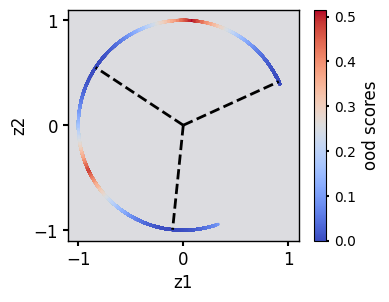

In [38]:
fig,ax = plt.subplots(1,1,figsize=(4,3))
for axis in ['top','bottom','left','right']:
    ax.spines[axis].set_linewidth(1)
ax.set_aspect('equal')

c = ax.scatter(features[:,0],features[:,1],c=ood_scores,cmap='coolwarm',s=1,alpha=1)
cb = fig.colorbar(c)
cb.ax.tick_params(labelsize=10,length=2.5,width=1.5)
cb.set_label('ood scores',fontsize=12)

ax.plot([0,state_centers[0,0]],[0,state_centers[0,1]],linewidth=2,color='black',linestyle='--')
ax.plot([0,state_centers[1,0]],[0,state_centers[1,1]],linewidth=2,color='black',linestyle='--')
ax.plot([0,state_centers[2,0]],[0,state_centers[2,1]],linewidth=2,color='black',linestyle='--')

ax.tick_params(axis="both",labelsize=12,direction='out',length=3.5,width=1.5)

ax.set_xlim(-1.1,1.1)
ax.set_ylim(-1.1,1.1)

ax.set_xticks([-1,0,1])
ax.set_yticks([-1,0,1])

ax.set_xlabel('z1',fontsize=12)
ax.set_ylabel('z2',fontsize=12)

r=0.1
g=0.1
b=0.2
ax.patch.set_facecolor((r,g,b,.15))

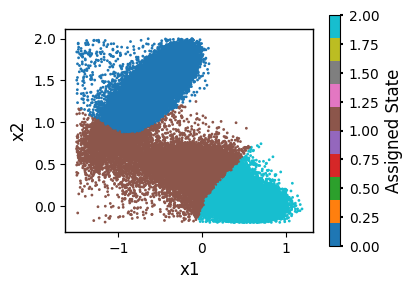

In [39]:
assigned_states = tsdart_model.transform(data, return_type='states').astype(int)

fig, ax = plt.subplots(1, 1, figsize=(4, 3))
for axis in ['top', 'bottom', 'left', 'right']:
    ax.spines[axis].set_linewidth(1)
ax.set_aspect('equal')

scatter = ax.scatter(data[:, 0], data[:, 1], c=assigned_states, cmap='tab10', s=1, alpha=1)
cb = fig.colorbar(scatter)
cb.ax.tick_params(labelsize=10, length=2.5, width=1.5)
cb.set_label('Assigned State', fontsize=12)

ax.set_xlabel('x1', fontsize=12)
ax.set_ylabel('x2', fontsize=12)
plt.show()

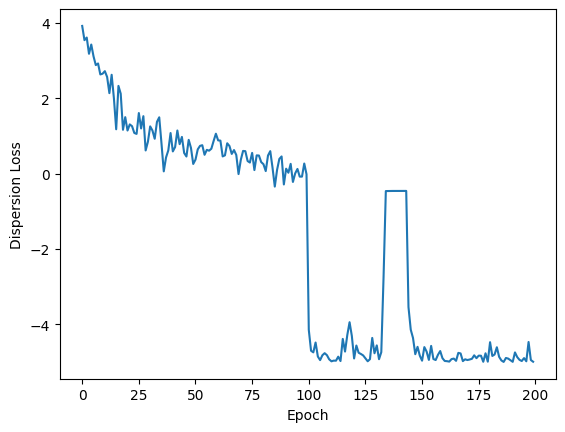

In [40]:
# dispersion loss
disloss = tsdart._validation_dis

plt.plot(range(len(disloss)), disloss)
plt.xlabel('Epoch')
plt.ylabel('Dispersion Loss')
plt.show()

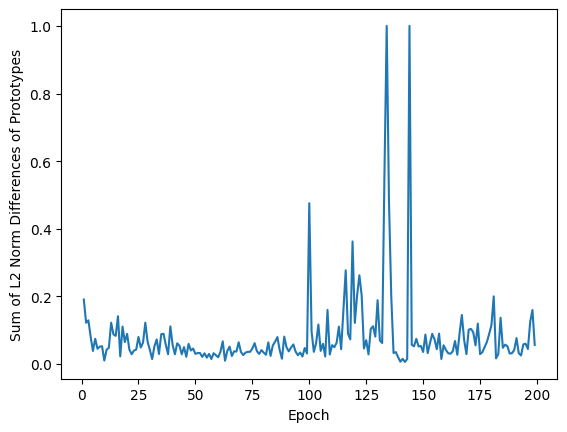

In [41]:
# prototypes_history
prototypes_history = tsdart.validation_prototypes
l2_diffs = []
for i in range(1, len(prototypes_history)):
    prev = prototypes_history[i-1]
    curr = prototypes_history[i]
    # compute L2-norm difference for each prototype
    diff = np.linalg.norm(curr - prev, axis=1)
    # max(Delta(L2-norm))
    l2_diffs.append(diff.max())

plt.plot(range(1, len(prototypes_history)), l2_diffs)
plt.xlabel('Epoch')
plt.ylabel('Sum of L2 Norm Differences of Prototypes')
plt.show()